In [2]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import load_model


from preprocessing.image import extract_features, extract_feature_from_image
from preprocessing.text import create_tokenizer
from NIC import greedy_inference_model, image_dense_lstm, text_emb_lstm
from evaluate import decoder, beam_search

In [3]:
# use training token set to create vocabulary
train_dir = './datasets/Flickr8k_text/Flickr_8k.trainImages.txt'
token_dir = './datasets/Flickr8k_text/Flickr8k.token.txt'
# the current best trained model
model_dir = './model-params-his/current_best.h5'

In [4]:
# load vocabulary
tokenizer = create_tokenizer(train_dir, token_dir, start_end = True, use_all=True)

# set relevent parameters
vocab_size  = tokenizer.num_words or (len(tokenizer.word_index)+1)
max_len = 24 # use 24 as maximum sentence's length when training the model

## Greedy inference

In [6]:
NIC_inference = greedy_inference_model(vocab_size, max_len)
NIC_inference.load_weights(model_dir, by_name = True, skip_mismatch=True)

In [7]:
def generate_caption_from_file(file_dir):
    # Encoder
    img_feature = extract_feature_from_image(file_dir)
    # Decoder
    caption = decoder(NIC_inference, tokenizer, img_feature, True)
    
    return caption

def generate_caption_from_directory(file_directory):
    # Encoder
    img_features_dict = extract_features(file_directory)
    # Decoder
    captions = decoder(NIC_inference, tokenizer, img_features_dict['features'], True)
    
    return img_features_dict['ids'], captions

1/1 [==============================] - 0s 55ms/step


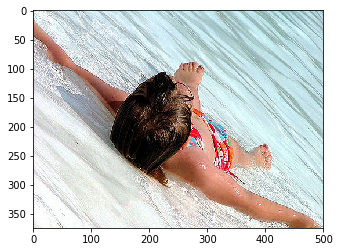

['a girl in a bikini is jumping into a pool']


In [11]:
image_file_dir = './put-your-image-here/example.jpg'

# display image
img = mpimg.imread(image_file_dir)
plt.imshow(img)

#generate caption
caption = generate_caption_from_file(image_file_dir)
plt.show()

print(caption)

In [ ]:
image_dir = './put-your-image-here'

img_names, captions = generate_caption_from_directory(image_dir)

for img_file in os.listdir(image_dir):
    img = mpimg.imread(image_dir + '/' + img_file)
    plt.imshow(img)
    
    img_name = os.path.splitext(img_file)[0]
    idx = img_names.index(img_name)
    
    plt.show()
    print(captions[idx])

## Beam search inference

In [12]:
# prepare inference model
NIC_text_emb_lstm = text_emb_lstm(vocab_size)
NIC_text_emb_lstm.load_weights(model_dir, by_name = True, skip_mismatch=True)
NIC_image_dense_lstm = image_dense_lstm()
NIC_image_dense_lstm.load_weights(model_dir, by_name = True, skip_mismatch=True)

In [13]:
def generate_caption_from_file(file_dir, beam_width = 5, alpha = 0.7):
    # Encoder
    img_feature = extract_feature_from_image(file_dir)
    # Decoder
    a0, c0 = NIC_image_dense_lstm.predict([img_feature, np.zeros([1, 512]), np.zeros([1, 512])])
    
    res = beam_search(NIC_text_emb_lstm, a0, c0, tokenizer, beam_width, max_len, alpha)
    best_idx = np.argmax(res['scores'])
    caption = tokenizer.sequences_to_texts([res['routes'][best_idx]])[0]
    
    return caption

def generate_caption_from_directory(file_directory, beam_width = 5, alpha = 0.7):
    # Encoder
    img_features_dict = extract_features(file_directory)
    # Decoder
    N = img_features_dict['features'].shape[0]
    a0, c0 = NIC_image_dense_lstm.predict([img_features_dict['features'], np.zeros([N, 512]), np.zeros([N, 512])])
    
    captions = []
    for i in range(N):
        res = beam_search(NIC_text_emb_lstm, a0[i, :].reshape(1,-1), c0[i, :].reshape(1,-1), tokenizer, beam_width, max_len, alpha)
        best_idx = np.argmax(res['scores'])
        captions.append(tokenizer.sequences_to_texts([res['routes'][best_idx]])[0])
    
    return img_features_dict['ids'], captions

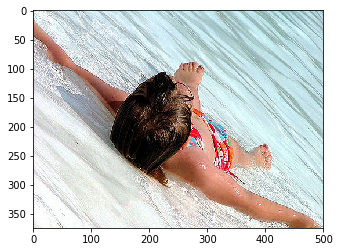

a girl in a bathing suit is playing in the water


In [14]:
image_file_dir = './put-your-image-here/example.jpg'

# display image
img = mpimg.imread(image_file_dir)
plt.imshow(img)

#generate caption
caption = generate_caption_from_file(image_file_dir)
plt.show()

print(caption)

In [ ]:
image_dir = './put-your-image-here'

img_names, captions = generate_caption_from_directory(image_dir, 10, 1)

for img_file in os.listdir(image_dir):
    img = mpimg.imread(image_dir + '/' + img_file)
    plt.imshow(img)
    
    img_name = os.path.splitext(img_file)[0]
    idx = img_names.index(img_name)
    
    plt.show()
    print(captions[idx])